In [ ]:
import glob
import time
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers  import PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:


def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    # activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    # res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = PReLU(shared_axes=[1, 2])(res)  # PRelu here

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res


def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (32, 32, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation=PReLU(shared_axes=[1, 2]))(
        input_layer)  # PReLu here

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block

    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(
        gen3)  # changed sequence here first conv then upsampling
    gen4 = UpSampling2D(size=2)(gen4)
    gen4 = PReLU(shared_axes=[1, 2])(gen4)
    # gen4 = Activation('relu')(gen4)                                                                                                   #PRelu here

    # Add another upsampling block
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen5 = UpSampling2D(size=2)(gen5)  # changed sequence here first conv then upsampling
    gen5 = PReLU(shared_axes=[1, 2])(gen5)
    # gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model


def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (128, 128, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = BatchNormalization(momentum=momentum)(dis2)  # changed seq in disc 2,3,4,5,6,7, here first BN then leakyRelu
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)

    dis3 = BatchNormalization(momentum=momentum)(dis3)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)

    dis4 = BatchNormalization(momentum=0.8)(dis4)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(128, kernel_size=3, strides=1, padding='same')(dis4)

    dis5 = BatchNormalization(momentum=momentum)(dis5)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis5)

    dis6 = BatchNormalization(momentum=momentum)(dis6)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)

    dis7 = BatchNormalization(momentum=momentum)(dis7)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)

    dis8 = BatchNormalization(momentum=momentum)(dis8)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model


def vgg_loss(y_true, y_pred):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    loss_model.trainable = False
    vggloss = K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
    #print("vgg loss", vggloss)
    return vggloss


def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x, gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)
    print("gan compiled!")

    return gan


def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = cv2.imread(img, cv2.COLOR_BGR2GRAY)

        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = resize(img1, high_resolution_shape)
        img1_low_resolution = resize(img1, low_resolution_shape)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)


def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    psnr_val = int(PSNR(original_image, generated_image)*1000)
    ssim_val = int(SSIM(original_image, generated_image)*1000)
    plt.text(-50, -50, "PSNR: {} , SSIM: {}".format(psnr_val/1000, ssim_val/1000))

    plt.savefig(path)


def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0).numpy()


def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0).numpy()


tf.config.run_functions_eagerly(True)
if __name__ == '__main__':

    epochs = 10001
    batch_size = 1
    mode = 'train'
    data_dir = root_path+"*.*"

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (32, 32, 3)
    high_resolution_shape = (128, 128, 3)

    adam = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    generator = build_generator()
    generator.compile(loss=vgg_loss, optimizer=adam)
    discriminator = build_discriminator()
    discriminator.compile(loss="binary_crossentropy", optimizer=adam)
    gan = get_gan_network(discriminator, low_resolution_shape, generator, adam)

    # Add Tensorboard

    for epoch in range(epochs):

        print("Epoch:{}".format(epoch))

        """
                                        Train the        D I S C R I M I N A T O R network
        """

        # Sample a batch of images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator.predict(low_resolution_images)

        # Generate batch of real and fake labels
        real_labels = np.ones((batch_size, 8, 8, 1))
        fake_labels = np.zeros((batch_size, 8, 8, 1))

        # Train the discriminator network on real and fake images
        d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

        # Calculate total discriminator loss
        # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print("d_loss_real & d_loss_fake: ", d_loss_real, "____", d_loss_fake)

        """
                                        Train the      G E N E R A T O R  network
        """

        # Sample a batch of images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)

        # Normalize images
        high_resolution_images = high_resolution_images / 255  # normalized images between 0-1 , earlier it was -1 to + 1
        low_resolution_images = low_resolution_images / 255

        discriminator.trainable = False

        loss_gan = gan.train_on_batch(low_resolution_images, (high_resolution_images, fake_labels))

        generated_high_resolution_images = generator.predict(low_resolution_images)
        psnr_score = PSNR(high_resolution_images, generated_high_resolution_images)
        ssim_score = SSIM(high_resolution_images, generated_high_resolution_images)

        print("PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , ")
        print(psnr_score, ssim_score, d_loss_real, d_loss_fake, loss_gan )

        # Write the losses to Tensorboard

        if epoch % 50 == 0:
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 255
            low_resolution_images = low_resolution_images / 255

            generated_images = generator.predict_on_batch(low_resolution_images)

            for index, img in enumerate(generated_images):
                save_images(low_resolution_images[index], high_resolution_images[index], img,
                            path="/content/output02/img_{}_{}".format(epoch, index))

    # Save models
    generator.save("/content/output02/generator_02.h5")
    discriminator.save("/content/output02/discriminator_02.h5")


gan compiled!
Epoch:0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


d_loss_real & d_loss_fake:  0.7541005611419678 ____ 0.9242072701454163
80142336/80134624 [==============================] - 1s 0us/step
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.915999] [0.00615144] 0.7541005611419678 0.9242072701454163 [0.09266629070043564, 0.09196038544178009, 0.7059084177017212]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1
d_loss_real & d_loss_fake:  0.5882033109664917 ____ 0.9123790264129639
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.591535] [0.07480042] 0.5882033109664917 0.9123790264129639 [0.07887716591358185, 0.0781501904129982, 0.7269750237464905]
Epoch:2
d_loss_real & d_loss_fake:  0.5480431914329529 ____ 0.9066260457038879
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.5048833] [0.07356922] 0.5480431914329529 0.9066260457038879 [0.08563333749771118, 0.08484916388988495, 0.7841759920120239]
Epoch:3
d_loss_real & d_loss_fake:  0.5005543231964111 ____ 0.8832107782363892
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.5914717] [0.03338124] 0.5005543231964111 0.8832107782363892 [0.07914868742227554, 0.07839611917734146, 0.7525668740272522]
Epoch:4
d_loss_real & d_loss_fake:  0.5987083911895752 ____ 0.7834092974662781
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.756852] [0.06289315] 0.5987083911895752 0.7834092974662781 [0.07916924357414246, 0.07841963320970535, 0.7496134042739868]
Epoch:5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:51
d_loss_real & d_loss_fake:  0.11129742860794067 ____ 0.041454754769802094
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.3259535] [0.21670894] 0.11129742860794067 0.041454754769802094 [0.05101388320326805, 0.046692509204149246, 4.321375370025635]
Epoch:52
d_loss_real & d_loss_fake:  0.03577754274010658 ____ 0.22657132148742676
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.624136] [0.22767557] 0.03577754274010658 0.22657132148742676 [0.06619864702224731, 0.06357453763484955, 2.6241097450256348]
Epoch:53
d_loss_real & d_loss_fake:  0.09518512338399887 ____ 0.5362123250961304
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.755491] [0.11637133] 0.09518512338399887 0.5362123250961304 [0.056117985397577286, 0.055595703423023224, 0.5222804546356201]
Epoch:54
d_loss_real & d_loss_fake:  0.030107323080301285 ____ 0.11794756352901459
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.3662724] [0.21734317] 0.030107323080301285 0.11794756352901459 [0.05460093542933464, 0.05456160008907318, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:101
d_loss_real & d_loss_fake:  0.025289949029684067 ____ 0.013580990955233574
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.4117703] [0.26472545] 0.025289949029684067 0.013580990955233574 [0.04846617206931114, 0.048456575721502304, 0.009594985283911228]
Epoch:102
d_loss_real & d_loss_fake:  0.021594781428575516 ____ 0.01172148808836937
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.800254] [0.27162638] 0.021594781428575516 0.01172148808836937 [0.061975255608558655, 0.06196283549070358, 0.012419125065207481]
Epoch:103
d_loss_real & d_loss_fake:  0.03848680108785629 ____ 0.0056589324958622456
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.040663] [0.29344586] 0.03848680108785629 0.0056589324958622456 [0.04567740485072136, 0.04566922411322594, 0.008180106990039349]
Epoch:104
d_loss_real & d_loss_fake:  0.03454025834798813 ____ 0.007624682504683733
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.136365] [0.21888597] 0.03454025834798813 0.007624682504683733 [0.03440776467323303, 0.03

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:151
d_loss_real & d_loss_fake:  0.01969977095723152 ____ 0.03826255723834038
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.940422] [0.11677218] 0.01969977095723152 0.03826255723834038 [0.07702305167913437, 0.07701684534549713, 0.006202722433954477]
Epoch:152
d_loss_real & d_loss_fake:  0.01983722113072872 ____ 0.022761087864637375
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.0064964] [0.19967157] 0.01983722113072872 0.022761087864637375 [0.03749541938304901, 0.037490248680114746, 0.005170744843780994]
Epoch:153
d_loss_real & d_loss_fake:  0.013398919254541397 ____ 0.019462868571281433
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.7903957] [0.15877889] 0.013398919254541397 0.019462868571281433 [0.06090691685676575, 0.06090275198221207, 0.004163051024079323]
Epoch:154
d_loss_real & d_loss_fake:  0.004815928637981415 ____ 0.02036258764564991
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.769739] [0.21263526] 0.004815928637981415 0.02036258764564991 [0.049010101705789566, 0.04900

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:201
d_loss_real & d_loss_fake:  0.005557004362344742 ____ 0.00525165069848299
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.679995] [0.2129515] 0.005557004362344742 0.00525165069848299 [0.04454348236322403, 0.044469527900218964, 0.0739559754729271]
Epoch:202
d_loss_real & d_loss_fake:  0.005340573377907276 ____ 0.0053458446636796
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7229304] [0.19098817] 0.005340573377907276 0.0053458446636796 [0.054825976490974426, 0.05474039912223816, 0.085577592253685]
Epoch:203
d_loss_real & d_loss_fake:  0.0059037525206804276 ____ 0.0049555497244000435
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[3.981315] [0.23833293] 0.0059037525206804276 0.0049555497244000435 [0.04400435462594032, 0.04391102120280266, 0.09333421289920807]
Epoch:204
d_loss_real & d_loss_fake:  0.0056585329584777355 ____ 0.008405623026192188
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.8718953] [0.31714925] 0.0056585329584777355 0.008405623026192188 [0.041329797357320786, 0.041

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:251
d_loss_real & d_loss_fake:  0.0030247210524976254 ____ 0.004285893402993679
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.243715] [0.26049158] 0.0030247210524976254 0.004285893402993679 [0.04152626171708107, 0.04149521142244339, 0.031051084399223328]
Epoch:252
d_loss_real & d_loss_fake:  0.003156601684167981 ____ 0.004208760801702738
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.504759] [0.22084154] 0.003156601684167981 0.004208760801702738 [0.029051264747977257, 0.029020393267273903, 0.03087056428194046]
Epoch:253
d_loss_real & d_loss_fake:  0.004689177498221397 ____ 0.00458000972867012
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.127513] [0.34275794] 0.004689177498221397 0.00458000972867012 [0.04685074836015701, 0.04683264344930649, 0.018104879185557365]
Epoch:254
d_loss_real & d_loss_fake:  0.0026536164805293083 ____ 0.0028651822358369827
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.5502653] [0.28658772] 0.0026536164805293083 0.0028651822358369827 [0.0367496646940708

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:301
d_loss_real & d_loss_fake:  0.005165652371942997 ____ 0.0022558397613465786
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.0821176] [0.22769006] 0.005165652371942997 0.0022558397613465786 [0.05602119490504265, 0.05601169168949127, 0.009504272602498531]
Epoch:302
d_loss_real & d_loss_fake:  0.006660023238509893 ____ 0.0022017068695276976
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.14984] [0.30018845] 0.006660023238509893 0.0022017068695276976 [0.02884811721742153, 0.028836416080594063, 0.011701603420078754]
Epoch:303
d_loss_real & d_loss_fake:  0.003701881505548954 ____ 0.004338685888797045
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2443395] [0.3676282] 0.003701881505548954 0.004338685888797045 [0.026642246171832085, 0.026631943881511688, 0.010302162729203701]
Epoch:304
d_loss_real & d_loss_fake:  0.002066963817924261 ____ 0.0019695954397320747
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.5123596] [0.26222777] 0.002066963817924261 0.0019695954397320747 [0.045097365975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.9434776] [0.2599627] 0.001183830201625824 0.0010258941911160946 [0.029286742210388184, 0.02927393466234207, 0.012808382511138916]
Epoch:351
d_loss_real & d_loss_fake:  0.0015586507506668568 ____ 0.0010225424775853753
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.3783674] [0.25561324] 0.0015586507506668568 0.0010225424775853753 [0.05224210396409035, 0.05222924053668976, 0.012862931936979294]
Epoch:352
d_loss_real & d_loss_fake:  0.001518481643870473 ____ 0.0010190161410719156
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.567467] [0.3476973] 0.001518481643870473 0.0010190161410719156 [0.02818593755364418, 0.02817360684275627, 0.012330140918493271]
Epoch:353
d_loss_real & d_loss_fake:  0.0018075150437653065 ____ 0.00102614879142493
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.215909] [0.30714637] 0.0018075150437653065 0.00102614879142493 [0.032049063593149185, 0.03203822299838066, 0.01084211841225624]
Epoch:354
d_loss_real & d_loss_fake: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:401
d_loss_real & d_loss_fake:  0.0008560656569898129 ____ 0.001156429061666131
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.4157877] [0.34124848] 0.0008560656569898129 0.001156429061666131 [0.02317182347178459, 0.023148471489548683, 0.023351669311523438]
Epoch:402
d_loss_real & d_loss_fake:  0.0017959796823561192 ____ 0.0008807522244751453
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.6092787] [0.31520468] 0.0017959796823561192 0.0008807522244751453 [0.033778801560401917, 0.033764004707336426, 0.014796356670558453]
Epoch:403
d_loss_real & d_loss_fake:  0.0008276058943010867 ____ 0.0010654953075572848
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.957504] [0.24880211] 0.0008276058943010867 0.0010654953075572848 [0.031841568648815155, 0.03182220458984375, 0.019363069906830788]
Epoch:404
d_loss_real & d_loss_fake:  0.0007534729083999991 ____ 0.0009714241023175418
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.5074496] [0.3008134] 0.0007534729083999991 0.0009714241023175418 [0.02

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.068071] [0.3553678] 0.0007506698602810502 0.0008511791238561273 [0.02233262173831463, 0.02231486141681671, 0.0177598986774683]
Epoch:451
d_loss_real & d_loss_fake:  0.0009261964587494731 ____ 0.0007302489248104393
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.5439053] [0.332924] 0.0009261964587494731 0.0007302489248104393 [0.027786530554294586, 0.027765929698944092, 0.02060084044933319]
Epoch:452
d_loss_real & d_loss_fake:  0.0006714357296004891 ____ 0.0007408313686028123
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.5263667] [0.31459308] 0.0006714357296004891 0.0007408313686028123 [0.013034464791417122, 0.013013597577810287, 0.02086743153631687]
Epoch:453
d_loss_real & d_loss_fake:  0.0006769333267584443 ____ 0.0008170416695065796
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.423256] [0.32334363] 0.0006769333267584443 0.0008170416695065796 [0.025522921234369278, 0.025500547140836716, 0.02237393707036972]
Epoch:454
d_loss_real & d_loss_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:501
d_loss_real & d_loss_fake:  0.0009957912843674421 ____ 0.003082715906202793
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.747037] [0.31511328] 0.0009957912843674421 0.003082715906202793 [0.029321275651454926, 0.02928522229194641, 0.03605365380644798]
Epoch:502
d_loss_real & d_loss_fake:  0.0008117238758131862 ____ 0.002668138360604644
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0157313] [0.26330173] 0.0008117238758131862 0.002668138360604644 [0.0378495529294014, 0.03781009465456009, 0.03945644199848175]
Epoch:503
d_loss_real & d_loss_fake:  0.002336552133783698 ____ 0.004047187510877848
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.886182] [0.47349688] 0.002336552133783698 0.004047187510877848 [0.021521955728530884, 0.021497517824172974, 0.02443699538707733]
Epoch:504
d_loss_real & d_loss_fake:  0.0014179806457832456 ____ 0.002283812966197729
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.576727] [0.37499452] 0.0014179806457832456 0.002283812966197729 [0.020537119358778,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:551
d_loss_real & d_loss_fake:  0.0007185660069808364 ____ 0.0004583429836202413
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.067457] [0.28955176] 0.0007185660069808364 0.0004583429836202413 [0.019402362406253815, 0.019387129694223404, 0.015232572332024574]
Epoch:552
d_loss_real & d_loss_fake:  0.0008555325912311673 ____ 0.00045743619557470083
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[4.7777777] [0.27385128] 0.0008555325912311673 0.00045743619557470083 [0.023402884602546692, 0.02338808961212635, 0.014795511029660702]
Epoch:553
d_loss_real & d_loss_fake:  0.0012496551498770714 ____ 0.000724838930182159
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.744521] [0.2765734] 0.0012496551498770714 0.000724838930182159 [0.027821725234389305, 0.027806267142295837, 0.01545808743685484]
Epoch:554
d_loss_real & d_loss_fake:  0.0009559745667502284 ____ 0.0004611657641362399
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.1930366] [0.35547784] 0.0009559745667502284 0.0004611657641362399 [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4823494] [0.26350388] 0.0009516210411675274 0.00038825045339763165 [0.03163549304008484, 0.031615208834409714, 0.020284214988350868]
Epoch:601
d_loss_real & d_loss_fake:  0.0007670357008464634 ____ 0.00038625061279162765
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.8844986] [0.36431518] 0.0007670357008464634 0.00038625061279162765 [0.02201170288026333, 0.021993860602378845, 0.01784292794764042]
Epoch:602
d_loss_real & d_loss_fake:  0.0007261378923431039 ____ 0.00038437845068983734
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.0846844] [0.320238] 0.0007261378923431039 0.00038437845068983734 [0.027396144345402718, 0.02737814001739025, 0.018004853278398514]
Epoch:603
d_loss_real & d_loss_fake:  0.0007021452765911818 ____ 0.0003852527297567576
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.6732397] [0.26661682] 0.0007021452765911818 0.0003852527297567576 [0.026236100122332573, 0.026208657771348953, 0.027441855520009995]
Epoch:604
d_loss_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.3238306] [0.26864687] 0.00048474609502591193 0.00033121026353910565 [0.029453014954924583, 0.02941729873418808, 0.03571702167391777]
Epoch:651
d_loss_real & d_loss_fake:  0.0006177651230245829 ____ 0.0005846552085131407
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.1959605] [0.44270632] 0.0006177651230245829 0.0005846552085131407 [0.014523021876811981, 0.014490639790892601, 0.032382361590862274]
Epoch:652
d_loss_real & d_loss_fake:  0.000450658961199224 ____ 0.0007748689968138933
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.188315] [0.32442316] 0.000450658961199224 0.0007748689968138933 [0.013867612928152084, 0.013825966976583004, 0.04164612293243408]
Epoch:653
d_loss_real & d_loss_fake:  0.0005335880559869111 ____ 0.0010488203261047602
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.88718] [0.35869607] 0.0005335880559869111 0.0010488203261047602 [0.014743355102837086, 0.014701629057526588, 0.0417260080575943]
Epoch:654
d_loss_real & d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:701
d_loss_real & d_loss_fake:  0.0011713732965290546 ____ 0.0003022759628947824
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.4367886] [0.3632971] 0.0011713732965290546 0.0003022759628947824 [0.014772673137485981, 0.014746812172234058, 0.025861311703920364]
Epoch:702
d_loss_real & d_loss_fake:  0.0006636247271671891 ____ 0.0002850415767170489
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.8326545] [0.41165304] 0.0006636247271671891 0.0002850415767170489 [0.026957832276821136, 0.026933792978525162, 0.024039600044488907]
Epoch:703
d_loss_real & d_loss_fake:  0.00044953881297260523 ____ 0.00026824395172297955
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.009314] [0.3359503] 0.00044953881297260523 0.00026824395172297955 [0.012936338782310486, 0.012908954173326492, 0.027384275570511818]
Epoch:704
d_loss_real & d_loss_fake:  0.00044795271242037416 ____ 0.00027716049226000905
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.3499312] [0.38785526] 0.00044795271242037416 0.000277160492260

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.378976] [0.44255427] 0.0004887495888397098 0.00025613000616431236 [0.022977281361818314, 0.022940203547477722, 0.037078119814395905]
Epoch:751
d_loss_real & d_loss_fake:  0.0003047674836125225 ____ 0.0002558011910878122
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1844344] [0.43646583] 0.0003047674836125225 0.0002558011910878122 [0.030399741604924202, 0.030359990894794464, 0.03975103050470352]
Epoch:752
d_loss_real & d_loss_fake:  0.0002679186291061342 ____ 0.0002554277307353914
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.1531353] [0.48777047] 0.0002679186291061342 0.0002554277307353914 [0.011928348802030087, 0.011884106323122978, 0.04424256831407547]
Epoch:753
d_loss_real & d_loss_fake:  0.0011626064078882337 ____ 0.0002551538054831326
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[5.555348] [0.34429395] 0.0011626064078882337 0.0002551538054831326 [0.026954056695103645, 0.026905959472060204, 0.04809741675853729]
Epoch:754
d_loss_real &

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:801
d_loss_real & d_loss_fake:  0.0005994371022097766 ____ 0.00037923501804471016
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.3791466] [0.40374848] 0.0005994371022097766 0.00037923501804471016 [0.012593328021466732, 0.012547636404633522, 0.04569200426340103]
Epoch:802
d_loss_real & d_loss_fake:  0.000645459396764636 ____ 0.00038846093229949474
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.409629] [0.32275614] 0.000645459396764636 0.00038846093229949474 [0.01670490764081478, 0.016655651852488518, 0.04925597459077835]
Epoch:803
d_loss_real & d_loss_fake:  0.0002557537518441677 ____ 0.0004829244571737945
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.689913] [0.37345362] 0.0002557537518441677 0.0004829244571737945 [0.01535256952047348, 0.01531100831925869, 0.04156085476279259]
Epoch:804
d_loss_real & d_loss_fake:  0.0004982089740224183 ____ 0.0004017892642877996
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.798389] [0.2835813] 0.0004982089740224183 0.0004017892642877996 [0.0245

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.669274] [0.28297308] 0.00023163386504165828 0.00029187556356191635 [0.037145357578992844, 0.03707669675350189, 0.06866041570901871]
Epoch:851
d_loss_real & d_loss_fake:  0.0004327711649239063 ____ 0.00022925926896277815
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.357726] [0.351544] 0.0004327711649239063 0.00022925926896277815 [0.009677925147116184, 0.009623363614082336, 0.05456159636378288]
Epoch:852
d_loss_real & d_loss_fake:  0.0007464753580279648 ____ 0.0002437401271890849
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.9176855] [0.3299328] 0.0007464753580279648 0.0002437401271890849 [0.01728983223438263, 0.01725516840815544, 0.034663330763578415]
Epoch:853
d_loss_real & d_loss_fake:  0.00023882754612714052 ____ 0.00022838958830107003
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.5909405] [0.45176598] 0.00023882754612714052 0.00022838958830107003 [0.016329873353242874, 0.01629207469522953, 0.0377979539334774]
Epoch:854
d_loss_real & 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.544088] [0.36455074] 0.00017580989515408874 0.00022425265342462808 [0.013543269596993923, 0.013495044782757759, 0.04822508990764618]
Epoch:901
d_loss_real & d_loss_fake:  0.0003575564478524029 ____ 0.00021575577557086945
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.96732] [0.45977315] 0.0003575564478524029 0.00021575577557086945 [0.01564839482307434, 0.015609822236001492, 0.03857339173555374]
Epoch:902
d_loss_real & d_loss_fake:  0.0001995582424569875 ____ 0.00021318701328709722
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.004833] [0.39750767] 0.0001995582424569875 0.00021318701328709722 [0.012234262190759182, 0.01218925416469574, 0.045008137822151184]
Epoch:903
d_loss_real & d_loss_fake:  0.0004455219313967973 ____ 0.00021305878181010485
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.9616036] [0.25863215] 0.0004455219313967973 0.00021305878181010485 [0.03176098316907883, 0.03172486275434494, 0.036118969321250916]
Epoch:904
d_loss_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:951
d_loss_real & d_loss_fake:  0.0003673617902677506 ____ 0.00046956929145380855
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.5633206] [0.45163512] 0.0003673617902677506 0.00046956929145380855 [0.01349787786602974, 0.013430099003016949, 0.06777921319007874]
Epoch:952
d_loss_real & d_loss_fake:  0.0002813301980495453 ____ 0.0003046627971343696
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2309065] [0.37775442] 0.0002813301980495453 0.0003046627971343696 [0.02045225165784359, 0.020379314199090004, 0.07293808460235596]
Epoch:953
d_loss_real & d_loss_fake:  0.00034598022466525435 ____ 0.0003188539412803948
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.783284] [0.41090754] 0.00034598022466525435 0.0003188539412803948 [0.012620496563613415, 0.012550976127386093, 0.06952063739299774]
Epoch:954
d_loss_real & d_loss_fake:  0.0002558908308856189 ____ 0.00033440126571804285
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.531892] [0.51649505] 0.0002558908308856189 0.00033440126571804285 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.630264] [0.25618315] 0.00014064174320083112 0.00030258914921432734 [0.021536201238632202, 0.021464407444000244, 0.07179353386163712]
Epoch:1001
d_loss_real & d_loss_fake:  0.0002083779836539179 ____ 0.00019135470211040229
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.390127] [0.27966344] 0.0002083779836539179 0.00019135470211040229 [0.027169985696673393, 0.027085494250059128, 0.08449063450098038]
Epoch:1002
d_loss_real & d_loss_fake:  0.00031968788243830204 ____ 0.00026417564367875457
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.349761] [0.37524477] 0.00031968788243830204 0.00026417564367875457 [0.009740961715579033, 0.00966622307896614, 0.0747389942407608]
Epoch:1003
d_loss_real & d_loss_fake:  0.0003800395643338561 ____ 0.00018489538342691958
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.532712] [0.36663604] 0.0003800395643338561 0.00018489538342691958 [0.012547286227345467, 0.012494584545493126, 0.052701618522405624]
Epoch:1004
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7765603] [0.38507643] 0.004135678056627512 0.0037700131069868803 [0.021856434643268585, 0.014826865866780281, 7.029567718505859]
Epoch:1051
d_loss_real & d_loss_fake:  0.013444135896861553 ____ 0.006920576561242342
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.059065] [0.45824406] 0.013444135896861553 0.006920576561242342 [0.024988478049635887, 0.014647424221038818, 10.341053009033203]
Epoch:1052
d_loss_real & d_loss_fake:  0.008324557915329933 ____ 0.0030689965933561325
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0847054] [0.26430115] 0.008324557915329933 0.0030689965933561325 [0.041834261268377304, 0.029410619288682938, 12.423641204833984]
Epoch:1053
d_loss_real & d_loss_fake:  0.005998243112117052 ____ 0.0028309011831879616
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.235483] [0.3532333] 0.005998243112117052 0.0028309011831879616 [0.03100183978676796, 0.020388728007674217, 10.61311149597168]
Epoch:1054
d_loss_real & d_loss_fake:  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1101
d_loss_real & d_loss_fake:  0.00082357507199049 ____ 0.0006168244290165603
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.9291086] [0.3845055] 0.00082357507199049 0.0006168244290165603 [0.026656821370124817, 0.01527911052107811, 11.377711296081543]
Epoch:1102
d_loss_real & d_loss_fake:  0.0009306691354140639 ____ 0.0006108491797931492
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.8214545] [0.35942698] 0.0009306691354140639 0.0006108491797931492 [0.02408864162862301, 0.014096186496317387, 9.992454528808594]
Epoch:1103
d_loss_real & d_loss_fake:  0.001205596374347806 ____ 0.0006050247466191649
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.9813766] [0.37440458] 0.001205596374347806 0.0006050247466191649 [0.03305060416460037, 0.021968498826026917, 11.082106590270996]
Epoch:1104
d_loss_real & d_loss_fake:  0.0014460753882303834 ____ 0.0005996301188133657
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.863529] [0.5023005] 0.0014460753882303834 0.0005996301188133657 [0.02263392135

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.889347] [0.3516402] 0.0004181404656264931 0.00037667760625481606 [0.026060834527015686, 0.016038835048675537, 10.021998405456543]
Epoch:1151
d_loss_real & d_loss_fake:  0.000638775120023638 ____ 0.0004148152656853199
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.6764107] [0.5311222] 0.000638775120023638 0.0004148152656853199 [0.025670085102319717, 0.01664115861058235, 9.028926849365234]
Epoch:1152
d_loss_real & d_loss_fake:  0.001441665692254901 ____ 0.0003700321540236473
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.322177] [0.43796244] 0.001441665692254901 0.0003700321540236473 [0.02781333029270172, 0.016977787017822266, 10.835543632507324]
Epoch:1153
d_loss_real & d_loss_fake:  0.0006614552112296224 ____ 0.0003641519579105079
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.5429173] [0.5159815] 0.0006614552112296224 0.0003641519579105079 [0.018714483827352524, 0.006969476118683815, 11.74500846862793]
Epoch:1154
d_loss_real & d_loss_fake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7945952] [0.46731386] 0.001388657372444868 0.0002989126951433718 [0.020884215831756592, 0.01431650947779417, 6.567707061767578]
Epoch:1201
d_loss_real & d_loss_fake:  0.0005867009749636054 ____ 0.0003006592742167413
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.513969] [0.43430975] 0.0005867009749636054 0.0003006592742167413 [0.01657862402498722, 0.009518494829535484, 7.060129165649414]
Epoch:1202
d_loss_real & d_loss_fake:  0.00018140184693038464 ____ 0.0003001343284267932
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.125248] [0.37263373] 0.00018140184693038464 0.0003001343284267932 [0.02394828386604786, 0.016589965671300888, 7.358318328857422]
Epoch:1203
d_loss_real & d_loss_fake:  0.0004011807614006102 ____ 0.00030768231954425573
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.915438] [0.4610072] 0.0004011807614006102 0.00030768231954425573 [0.021298719570040703, 0.015064259991049767, 6.23445987701416]
Epoch:1204
d_loss_real & d_loss_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.759081] [0.31528747] 0.00020031543681398034 0.00032094470225274563 [0.02913568541407585, 0.015479277819395065, 13.656408309936523]
Epoch:1251
d_loss_real & d_loss_fake:  0.0006110530230216682 ____ 0.0004194491484668106
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.416948] [0.38274422] 0.0006110530230216682 0.0004194491484668106 [0.03379733860492706, 0.021871358156204224, 11.92597770690918]
Epoch:1252
d_loss_real & d_loss_fake:  0.0005380607908591628 ____ 0.000271358760073781
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3793106] [0.40651777] 0.0005380607908591628 0.000271358760073781 [0.03408769890666008, 0.021233977749943733, 12.853720664978027]
Epoch:1253
d_loss_real & d_loss_fake:  0.0003718063235282898 ____ 0.00026276306016370654
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3359303] [0.40371528] 0.0003718063235282898 0.00026276306016370654 [0.022739751264452934, 0.008942465297877789, 13.797285079956055]
Epoch:1254
d_loss_real & d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.209801] [0.46446297] 0.009444976225495338 0.0006747422739863396 [0.016460614278912544, 0.016439814120531082, 0.02080019749701023]
Epoch:1301
d_loss_real & d_loss_fake:  0.11071513593196869 ____ 0.0005387448472902179
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3956246] [0.3759131] 0.11071513593196869 0.0005387448472902179 [0.015024214051663876, 0.014984835870563984, 0.039378270506858826]
Epoch:1302
d_loss_real & d_loss_fake:  0.0034019204322248697 ____ 0.005543258041143417
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.304184] [0.5056862] 0.0034019204322248697 0.005543258041143417 [0.009253602474927902, 0.0090817641466856, 0.17183855175971985]
Epoch:1303
d_loss_real & d_loss_fake:  0.0012133658165112138 ____ 0.000782082206569612
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6347094] [0.35425445] 0.0012133658165112138 0.000782082206569612 [0.016377096995711327, 0.015632769092917442, 0.7443280220031738]
Epoch:1304
d_loss_real & d_loss_fak

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0699005] [0.40844846] 0.00030320079531520605 0.0003605970705393702 [0.012911603786051273, 0.011547880247235298, 1.3637237548828125]
Epoch:1351
d_loss_real & d_loss_fake:  0.0006238871719688177 ____ 0.0003410781791899353
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6747613] [0.4953407] 0.0006238871719688177 0.0003410781791899353 [0.012446064502000809, 0.010812435299158096, 1.6336288452148438]
Epoch:1352
d_loss_real & d_loss_fake:  0.0005037385271862149 ____ 0.0003374442458152771
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0958323] [0.26627836] 0.0005037385271862149 0.0003374442458152771 [0.029750540852546692, 0.026757879182696342, 2.9926607608795166]
Epoch:1353
d_loss_real & d_loss_fake:  0.00036188814556226134 ____ 0.0003338593814987689
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.00535] [0.404487] 0.00036188814556226134 0.0003338593814987689 [0.02540307119488716, 0.02144502103328705, 3.958050012588501]
Epoch:1354
d_loss_real & d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4718475] [0.34500727] 0.0007602690020576119 0.00026240156148560345 [0.021471815183758736, 0.016281787306070328, 5.190027236938477]
Epoch:1401
d_loss_real & d_loss_fake:  0.0003985913353972137 ____ 0.000245958159212023
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4242167] [0.40658435] 0.0003985913353972137 0.000245958159212023 [0.019460532814264297, 0.015101207420229912, 4.3593244552612305]
Epoch:1402
d_loss_real & d_loss_fake:  0.0005243923515081406 ____ 0.00024582771584391594
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.960985] [0.37053815] 0.0005243923515081406 0.00024582771584391594 [0.01837189495563507, 0.01612972468137741, 2.2421703338623047]
Epoch:1403
d_loss_real & d_loss_fake:  0.0004970464506186545 ____ 0.0002624853514134884
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1327624] [0.421394] 0.0004970464506186545 0.0002624853514134884 [0.01915406808257103, 0.01498518418520689, 4.16888427734375]
Epoch:1404
d_loss_real & d_loss_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1451
d_loss_real & d_loss_fake:  0.00018279076903127134 ____ 0.00018927703786175698
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1857057] [0.28658286] 0.00018279076903127134 0.00018927703786175698 [0.02180151641368866, 0.01891728863120079, 2.884227752685547]
Epoch:1452
d_loss_real & d_loss_fake:  0.00020945872529409826 ____ 0.00018736650235950947
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.201911] [0.42180124] 0.00020945872529409826 0.00018736650235950947 [0.021318919956684113, 0.016241446137428284, 5.077474594116211]
Epoch:1453
d_loss_real & d_loss_fake:  0.00013871661212760955 ____ 0.00018630264094099402
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.791734] [0.33915555] 0.00013871661212760955 0.00018630264094099402 [0.021292369812726974, 0.016886934638023376, 4.405435085296631]
Epoch:1454
d_loss_real & d_loss_fake:  8.386974513996392e-05 ____ 0.0001853447174653411
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2423024] [0.41066003] 8.386974513996392e-05 0.0001853447174653

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0300584] [0.48832035] 0.0003037089481949806 0.00016001799667719752 [0.011286389082670212, 0.007696689572185278, 3.5896995067596436]
Epoch:1501
d_loss_real & d_loss_fake:  0.00013931505964137614 ____ 0.00016001831681933254
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.161359] [0.39934433] 0.00013931505964137614 0.00016001831681933254 [0.020064759999513626, 0.01751480996608734, 2.54995059967041]
Epoch:1502
d_loss_real & d_loss_fake:  0.0002232854749308899 ____ 0.00018707895651459694
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7201014] [0.36173296] 0.0002232854749308899 0.00018707895651459694 [0.0180013719946146, 0.014152416959404945, 3.8489556312561035]
Epoch:1503
d_loss_real & d_loss_fake:  0.00039725645910948515 ____ 0.0001595284993527457
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.403301] [0.43152833] 0.00039725645910948515 0.0001595284993527457 [0.019631873816251755, 0.01588396728038788, 3.74790620803833]
Epoch:1504
d_loss_real & 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.515666] [0.42360392] 0.0002930616610683501 0.0001405099028488621 [0.014050317928195, 0.010627884417772293, 3.4224328994750977]
Epoch:1551
d_loss_real & d_loss_fake:  0.00013314819079823792 ____ 0.00014013322652317584
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.3906674] [0.50504] 0.00013314819079823792 0.00014013322652317584 [0.009227035567164421, 0.007159306667745113, 2.0677287578582764]
Epoch:1552
d_loss_real & d_loss_fake:  8.838329085847363e-05 ____ 0.00014135270612314343
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0846424] [0.5115337] 8.838329085847363e-05 0.00014135270612314343 [0.009734817780554295, 0.007946226745843887, 1.788590908050537]
Epoch:1553
d_loss_real & d_loss_fake:  0.00011315167648717761 ____ 0.00013974832836538553
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.652685] [0.43626145] 0.00011315167648717761 0.00013974832836538553 [0.017534874379634857, 0.01484966091811657, 2.685213804244995]
Epoch:1554
d_loss_real & d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.013755] [0.46008432] 0.00015395780792459846 0.00012458435958251357 [0.022770535200834274, 0.01977783441543579, 2.9927010536193848]
Epoch:1601
d_loss_real & d_loss_fake:  0.00010051480785477906 ____ 0.00012583220086526126
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.088774] [0.470441] 0.00010051480785477906 0.00012583220086526126 [0.015046200715005398, 0.011292075738310814, 3.754124641418457]
Epoch:1602
d_loss_real & d_loss_fake:  4.554537736112252e-05 ____ 0.00012802185665350407
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.668773] [0.44152555] 4.554537736112252e-05 0.00012802185665350407 [0.011427558027207851, 0.008776258677244186, 2.651298999786377]
Epoch:1603
d_loss_real & d_loss_fake:  6.125458457972854e-05 ____ 0.00012694313772954047
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.709516] [0.4513284] 6.125458457972854e-05 0.00012694313772954047 [0.008991462178528309, 0.007097399793565273, 1.8940619230270386]
Epoch:1604
d_loss_real &

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.8209286] [0.4707903] 8.058027742663398e-05 0.00012306722055654973 [0.01390557549893856, 0.01052999496459961, 3.3755807876586914]
Epoch:1651
d_loss_real & d_loss_fake:  0.0001273385132662952 ____ 0.00010913048754446208
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.591366] [0.39656833] 0.0001273385132662952 0.00010913048754446208 [0.017031749710440636, 0.013150975108146667, 3.880774974822998]
Epoch:1652
d_loss_real & d_loss_fake:  5.450664320960641e-05 ____ 0.00010884115181397647
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.954956] [0.44922915] 5.450664320960641e-05 0.00010884115181397647 [0.017686299979686737, 0.014683213084936142, 3.003087282180786]
Epoch:1653
d_loss_real & d_loss_fake:  0.00010878555622184649 ____ 0.00010844059579540044
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0101438] [0.31961524] 0.00010878555622184649 0.00010844059579540044 [0.024069519713521004, 0.020465033128857613, 3.6044859886169434]
Epoch:1654
d_loss_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.07376] [0.40648326] 4.095870099263266e-05 9.849947673501447e-05 [0.01473201159387827, 0.012620745226740837, 2.111266613006592]
Epoch:1701
d_loss_real & d_loss_fake:  0.00014729669783264399 ____ 9.863237937679514e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3745427] [0.41920826] 0.00014729669783264399 9.863237937679514e-05 [0.02065499685704708, 0.018747976049780846, 1.907020092010498]
Epoch:1702
d_loss_real & d_loss_fake:  0.00010138159268535674 ____ 9.999457688536495e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.507835] [0.4690374] 0.00010138159268535674 9.999457688536495e-05 [0.01672990992665291, 0.014458215795457363, 2.2716941833496094]
Epoch:1703
d_loss_real & d_loss_fake:  0.00014858748181723058 ____ 9.841719293035567e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.043647] [0.39498648] 0.00014858748181723058 9.841719293035567e-05 [0.016016382724046707, 0.013585645705461502, 2.4307377338409424]
Epoch:1704
d_loss_real & d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.8518405] [0.4581878] 8.337485633092001e-05 9.42856349865906e-05 [0.014209896326065063, 0.009355232119560242, 4.854663372039795]
Epoch:1751
d_loss_real & d_loss_fake:  4.60142400697805e-05 ____ 9.404368756804615e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.7511907] [0.45021734] 4.60142400697805e-05 9.404368756804615e-05 [0.018423400819301605, 0.013853750191628933, 4.569649696350098]
Epoch:1752
d_loss_real & d_loss_fake:  0.00011758295295294374 ____ 9.339567623101175e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.07007] [0.44879484] 0.00011758295295294374 9.339567623101175e-05 [0.016529714688658714, 0.012012491002678871, 4.517223834991455]
Epoch:1753
d_loss_real & d_loss_fake:  0.00012048254575347528 ____ 9.316443174611777e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.2846] [0.41859198] 0.00012048254575347528 9.316443174611777e-05 [0.020617157220840454, 0.015845859423279762, 4.771298408508301]
Epoch:1754
d_loss_real & d_loss_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7007256] [0.4320462] 7.44549251976423e-05 8.475511276628822e-05 [0.015850234776735306, 0.01219920627772808, 3.6510281562805176]
Epoch:1801
d_loss_real & d_loss_fake:  0.00022065831581130624 ____ 8.456487557850778e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.057119] [0.40077463] 0.00022065831581130624 8.456487557850778e-05 [0.01699960231781006, 0.011661808006465435, 5.337794303894043]
Epoch:1802
d_loss_real & d_loss_fake:  8.249894744949415e-05 ____ 8.743940270505846e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1735735] [0.47919694] 8.249894744949415e-05 8.743940270505846e-05 [0.01404966413974762, 0.008599160239100456, 5.450504302978516]
Epoch:1803
d_loss_real & d_loss_fake:  0.0002023390115937218 ____ 8.489735773764551e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.442528] [0.35150376] 0.0002023390115937218 8.489735773764551e-05 [0.019043052569031715, 0.014910165220499039, 4.13288688659668]
Epoch:1804
d_loss_real & d_loss_f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4906783] [0.42283556] 5.1954248192487285e-05 7.730293145868927e-05 [0.016870060935616493, 0.013121064752340317, 3.7489962577819824]
Epoch:1851
d_loss_real & d_loss_fake:  6.359555118251592e-05 ____ 7.715190440649167e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6162024] [0.4497393] 6.359555118251592e-05 7.715190440649167e-05 [0.012925400398671627, 0.009742839261889458, 3.182560920715332]
Epoch:1852
d_loss_real & d_loss_fake:  0.0001679173728916794 ____ 7.699821435380727e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.467902] [0.47387537] 0.0001679173728916794 7.699821435380727e-05 [0.015014776028692722, 0.011154992505908012, 3.859783172607422]
Epoch:1853
d_loss_real & d_loss_fake:  0.00026216794503852725 ____ 7.688408368267119e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[9.251888] [0.3275821] 0.00026216794503852725 7.688408368267119e-05 [0.019005943089723587, 0.0152144655585289, 3.791477918624878]
Epoch:1854
d_loss_real & d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.150019] [0.43732706] 4.00274911953602e-05 7.099454523995519e-05 [0.023330288007855415, 0.020818352699279785, 2.511935234069824]
Epoch:1901
d_loss_real & d_loss_fake:  0.00014271748659666628 ____ 0.0001486365799792111
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7548003] [0.42172348] 0.00014271748659666628 0.0001486365799792111 [0.012312219478189945, 0.008650276809930801, 3.661942720413208]
Epoch:1902
d_loss_real & d_loss_fake:  7.729596109129488e-05 ____ 7.293623639270663e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.375768] [0.3988018] 7.729596109129488e-05 7.293623639270663e-05 [0.017155013978481293, 0.012302186340093613, 4.852828502655029]
Epoch:1903
d_loss_real & d_loss_fake:  6.922738975845277e-05 ____ 0.00011246285430388525
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.521344] [0.43273583] 6.922738975845277e-05 0.00011246285430388525 [0.013362505473196507, 0.008255694061517715, 5.106811046600342]
Epoch:1904
d_loss_real & d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2484875] [0.5020879] 0.0001300400181207806 6.928420771146193e-05 [0.013122979551553726, 0.011320201680064201, 1.8027780055999756]
Epoch:1951
d_loss_real & d_loss_fake:  7.575926429126412e-05 ____ 6.47676206426695e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.298762] [0.47489837] 7.575926429126412e-05 6.47676206426695e-05 [0.011373702436685562, 0.009463248774409294, 1.9104533195495605]
Epoch:1952
d_loss_real & d_loss_fake:  0.00011600583820836619 ____ 6.465057958848774e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.813348] [0.45917067] 0.00011600583820836619 6.465057958848774e-05 [0.01145150326192379, 0.00922304205596447, 2.2284605503082275]
Epoch:1953
d_loss_real & d_loss_fake:  7.101894880179316e-05 ____ 6.454307003878057e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.701931] [0.3752922] 7.101894880179316e-05 6.454307003878057e-05 [0.024657927453517914, 0.021500976756215096, 3.156949996948242]
Epoch:1954
d_loss_real & d_loss_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6785197] [0.43020275] 0.00014462883700616658 6.0654787375824526e-05 [0.01738739386200905, 0.012527449056506157, 4.859944820404053]
Epoch:2001
d_loss_real & d_loss_fake:  4.851935227634385e-05 ____ 6.0639617004198954e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.466464] [0.44499016] 4.851935227634385e-05 6.0639617004198954e-05 [0.014293359592556953, 0.010226089507341385, 4.067270278930664]
Epoch:2002
d_loss_real & d_loss_fake:  0.0002662084880284965 ____ 6.0619338910328224e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6547956] [0.4291433] 0.0002662084880284965 6.0619338910328224e-05 [0.02550949528813362, 0.023377850651741028, 2.1316442489624023]
Epoch:2003
d_loss_real & d_loss_fake:  0.0001344318880001083 ____ 6.060676969354972e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4608655] [0.4927589] 0.0001344318880001083 6.060676969354972e-05 [0.014091052114963531, 0.00975095946341753, 4.34009313583374]
Epoch:2004
d_loss_real & d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8080163] [0.44016537] 3.597711838665418e-05 5.634397530229762e-05 [0.01479138433933258, 0.010967989452183247, 3.823394298553467]
Epoch:2051
d_loss_real & d_loss_fake:  7.459608605131507e-05 ____ 5.615074769593775e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.5176167] [0.46785006] 7.459608605131507e-05 5.615074769593775e-05 [0.012085599824786186, 0.008841583505272865, 3.244016170501709]
Epoch:2052
d_loss_real & d_loss_fake:  3.5295051930006593e-05 ____ 5.6136203056667e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3325863] [0.45348394] 3.5295051930006593e-05 5.6136203056667e-05 [0.008235877379775047, 0.005063687451183796, 3.1721901893615723]
Epoch:2053
d_loss_real & d_loss_fake:  3.5599055991042405e-05 ____ 5.594009780907072e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.502428] [0.4467118] 3.5599055991042405e-05 5.594009780907072e-05 [0.010543286800384521, 0.008448832668364048, 2.094454288482666]
Epoch:2054
d_loss_real & d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.895163] [0.43837556] 4.3617845221888274e-05 5.304950900608674e-05 [0.01656554453074932, 0.013747062534093857, 2.818481683731079]
Epoch:2101
d_loss_real & d_loss_fake:  3.1838233553571627e-05 ____ 5.2947110816603526e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.138826] [0.292024] 3.1838233553571627e-05 5.2947110816603526e-05 [0.028655381873250008, 0.024766672402620316, 3.888709306716919]
Epoch:2102
d_loss_real & d_loss_fake:  4.7486515541095287e-05 ____ 5.284246435621753e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1218824] [0.46482396] 4.7486515541095287e-05 5.284246435621753e-05 [0.010736238211393356, 0.008188338950276375, 2.5478994846343994]
Epoch:2103
d_loss_real & d_loss_fake:  3.9995473343878984e-05 ____ 5.273585338727571e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.159288] [0.41000727] 3.9995473343878984e-05 5.273585338727571e-05 [0.013142121955752373, 0.010885220021009445, 2.2569022178649902]
Epoch:2104
d_loss_real 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.131619] [0.45973587] 5.333572335075587e-05 4.852304118685424e-05 [0.021821200847625732, 0.017984546720981598, 3.8366539478302]
Epoch:2151
d_loss_real & d_loss_fake:  2.6385085220681503e-05 ____ 4.8431124014314264e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.351145] [0.44698417] 2.6385085220681503e-05 4.8431124014314264e-05 [0.010211510583758354, 0.0054159509018063545, 4.795558929443359]
Epoch:2152
d_loss_real & d_loss_fake:  0.00016946514369919896 ____ 4.8346748371841386e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8022985] [0.52090853] 0.00016946514369919896 4.8346748371841386e-05 [0.013079674914479256, 0.01013324223458767, 2.9464330673217773]
Epoch:2153
d_loss_real & d_loss_fake:  4.0836515836417675e-05 ____ 4.827156590181403e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.965596] [0.39259037] 4.0836515836417675e-05 4.827156590181403e-05 [0.012626845389604568, 0.010064852423965931, 2.56199312210083]
Epoch:2154
d_loss_real 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8145986] [0.44365892] 3.0752653401577845e-05 4.5030486944597214e-05 [0.013619141653180122, 0.00980304554104805, 3.8160953521728516]
Epoch:2201
d_loss_real & d_loss_fake:  2.441092874505557e-05 ____ 4.4959084334550425e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2752013] [0.44923684] 2.441092874505557e-05 4.4959084334550425e-05 [0.014870377257466316, 0.011978361755609512, 2.892014980316162]
Epoch:2202
d_loss_real & d_loss_fake:  3.8186321035027504e-05 ____ 4.488266495172866e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.488922] [0.4379005] 3.8186321035027504e-05 4.488266495172866e-05 [0.01251324824988842, 0.009899968281388283, 2.613279342651367]
Epoch:2203
d_loss_real & d_loss_fake:  2.427079016342759e-05 ____ 4.480360439629294e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[9.377002] [0.35177675] 2.427079016342759e-05 4.480360439629294e-05 [0.014851117506623268, 0.011766479350626469, 3.0846383571624756]
Epoch:2204
d_loss_real & 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2251
d_loss_real & d_loss_fake:  4.05318132834509e-05 ____ 5.176849299459718e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3062572] [0.46486306] 4.05318132834509e-05 5.176849299459718e-05 [0.009832063689827919, 0.007855011150240898, 1.9770526885986328]
Epoch:2252
d_loss_real & d_loss_fake:  4.430611807038076e-05 ____ 4.851316043641418e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.266235] [0.4332308] 4.430611807038076e-05 4.851316043641418e-05 [0.02128932811319828, 0.017452135682106018, 3.837193012237549]
Epoch:2253
d_loss_real & d_loss_fake:  4.60976007161662e-05 ____ 4.31252847192809e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.770974] [0.42601058] 4.60976007161662e-05 4.31252847192809e-05 [0.016029726713895798, 0.01140480488538742, 4.6249213218688965]
Epoch:2254
d_loss_real & d_loss_fake:  3.492461837595329e-05 ____ 4.2581508751027286e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.578847] [0.43086627] 3.492461837595329e-05 4.2581508751027286e-05 [0.012853756

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.290806] [0.41837063] 3.8889927964191884e-05 3.991553239757195e-05 [0.012505169957876205, 0.009107833728194237, 3.397336483001709]
Epoch:2301
d_loss_real & d_loss_fake:  2.4082724848994985e-05 ____ 3.986370575148612e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.125609] [0.33115593] 2.4082724848994985e-05 3.986370575148612e-05 [0.02080095186829567, 0.01812869682908058, 2.6722540855407715]
Epoch:2302
d_loss_real & d_loss_fake:  5.5731528846081346e-05 ____ 3.981060945079662e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.08464] [0.3455949] 5.5731528846081346e-05 3.981060945079662e-05 [0.014740962535142899, 0.011853545904159546, 2.887416362762451]
Epoch:2303
d_loss_real & d_loss_fake:  4.321939923102036e-05 ____ 3.976027073804289e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.258949] [0.32102814] 4.321939923102036e-05 3.976027073804289e-05 [0.018637679517269135, 0.015585675835609436, 3.052004098892212]
Epoch:2304
d_loss_real & d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.843454] [0.4231068] 4.186460137134418e-05 3.811255737673491e-05 [0.012087213806807995, 0.010220007039606571, 1.8672068119049072]
Epoch:2351
d_loss_real & d_loss_fake:  8.564979361835867e-05 ____ 3.9903767174109817e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7106094] [0.39345667] 8.564979361835867e-05 3.9903767174109817e-05 [0.018143562600016594, 0.015337791293859482, 2.8057708740234375]
Epoch:2352
d_loss_real & d_loss_fake:  2.560694338171743e-05 ____ 3.844892853521742e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3323545] [0.4284711] 2.560694338171743e-05 3.844892853521742e-05 [0.012477802112698555, 0.009101159870624542, 3.3766417503356934]
Epoch:2353
d_loss_real & d_loss_fake:  5.190945012145676e-05 ____ 3.8032896554796025e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.2439556] [0.4513785] 5.190945012145676e-05 3.8032896554796025e-05 [0.012261273339390755, 0.008143190294504166, 4.118083477020264]
Epoch:2354
d_loss_real & 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2401
d_loss_real & d_loss_fake:  3.0239945772336796e-05 ____ 3.567002568161115e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.737016] [0.38495135] 3.0239945772336796e-05 3.567002568161115e-05 [0.017276708036661148, 0.014805137179791927, 2.4715700149536133]
Epoch:2402
d_loss_real & d_loss_fake:  1.539840013720095e-05 ____ 3.5612480132840574e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.298622] [0.4305632] 1.539840013720095e-05 3.5612480132840574e-05 [0.010931279510259628, 0.008437410928308964, 2.493868827819824]
Epoch:2403
d_loss_real & d_loss_fake:  1.566054197610356e-05 ____ 3.554933573468588e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.5172963] [0.4746313] 1.566054197610356e-05 3.554933573468588e-05 [0.010507667437195778, 0.007793215103447437, 2.714451789855957]
Epoch:2404
d_loss_real & d_loss_fake:  3.700629895320162e-05 ____ 3.548631502781063e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.672314] [0.33138713] 3.700629895320162e-05 3.548631502781063e-05 [0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.1193805] [0.48925886] 0.0001508067362010479 3.379711779416539e-05 [0.011969447135925293, 0.008487101644277573, 3.4823458194732666]
Epoch:2451
d_loss_real & d_loss_fake:  3.739679596037604e-05 ____ 3.440954242250882e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.28063] [0.46406627] 3.739679596037604e-05 3.440954242250882e-05 [0.012708969414234161, 0.009678777307271957, 3.030191421508789]
Epoch:2452
d_loss_real & d_loss_fake:  5.352073276299052e-05 ____ 4.141584213357419e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.13336] [0.40792653] 5.352073276299052e-05 4.141584213357419e-05 [0.013879167847335339, 0.009468941017985344, 4.410226821899414]
Epoch:2453
d_loss_real & d_loss_fake:  3.392629878362641e-05 ____ 3.6013469070894644e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.613323] [0.36035693] 3.392629878362641e-05 3.6013469070894644e-05 [0.012384772300720215, 0.00856538861989975, 3.8193836212158203]
Epoch:2454
d_loss_real & d_los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.622093] [0.4234972] 0.00038686118205077946 0.002729776781052351 [0.011094311252236366, 0.010551990941166878, 0.542320191860199]
Epoch:2501
d_loss_real & d_loss_fake:  0.0013296843972057104 ____ 0.0024710854049772024
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3685465] [0.523146] 0.0013296843972057104 0.0024710854049772024 [0.012961143627762794, 0.012384027242660522, 0.5771167278289795]
Epoch:2502
d_loss_real & d_loss_fake:  0.0007879444165155292 ____ 0.002074587158858776
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.423308] [0.4316138] 0.0007879444165155292 0.002074587158858776 [0.009543743915855885, 0.008938746526837349, 0.6049976944923401]
Epoch:2503
d_loss_real & d_loss_fake:  0.0023770069237798452 ____ 0.001728464849293232
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6023107] [0.4498454] 0.0023770069237798452 0.001728464849293232 [0.008823827840387821, 0.008231347426772118, 0.5924804210662842]
Epoch:2504
d_loss_real & d_loss_fake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8012342] [0.413476] 7.630241452716291e-05 0.0003078763547819108 [0.013085472397506237, 0.012749968096613884, 0.3355044722557068]
Epoch:2551
d_loss_real & d_loss_fake:  0.0011153663508594036 ____ 0.0001845375372795388
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.383865] [0.44167134] 0.0011153663508594036 0.0001845375372795388 [0.00895634014159441, 0.008675196208059788, 0.28114432096481323]
Epoch:2552
d_loss_real & d_loss_fake:  9.530239913146943e-05 ____ 0.00021359912352636456
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.0632615] [0.48052272] 9.530239913146943e-05 0.00021359912352636456 [0.007034079637378454, 0.006693873088806868, 0.3402063548564911]
Epoch:2553
d_loss_real & d_loss_fake:  0.0006828238838352263 ____ 0.0001839545730035752
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.914932] [0.44760585] 0.0006828238838352263 0.0001839545730035752 [0.006053701974451542, 0.005717362742871046, 0.3363390564918518]
Epoch:2554
d_loss_real & d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.519165] [0.4378066] 0.00014698939048685133 0.00010072805162053555 [0.010984075255692005, 0.010605204850435257, 0.3788701295852661]
Epoch:2601
d_loss_real & d_loss_fake:  0.00015228077245410532 ____ 0.00014068512246012688
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.101419] [0.39609602] 0.00015228077245410532 0.00014068512246012688 [0.009814975783228874, 0.009465496987104416, 0.34947890043258667]
Epoch:2602
d_loss_real & d_loss_fake:  3.6335950426291674e-05 ____ 0.0001253132795682177
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.334208] [0.317044] 3.6335950426291674e-05 0.0001253132795682177 [0.014692411758005619, 0.01429577637463808, 0.39663517475128174]
Epoch:2603
d_loss_real & d_loss_fake:  8.309324766742066e-05 ____ 8.786004036664963e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.818687] [0.50431675] 8.309324766742066e-05 8.786004036664963e-05 [0.007790378760546446, 0.007404809817671776, 0.3855688273906708]
Epoch:2604
d_loss_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.5493336] [0.45613202] 4.369136149762198e-05 7.022930367384106e-05 [0.010501334443688393, 0.010069837793707848, 0.4314962923526764]
Epoch:2651
d_loss_real & d_loss_fake:  0.00014149968046694994 ____ 6.86587009113282e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.7411933] [0.4040879] 0.00014149968046694994 6.86587009113282e-05 [0.013021656312048435, 0.01261662133038044, 0.40503454208374023]
Epoch:2652
d_loss_real & d_loss_fake:  0.00013211742043495178 ____ 5.641065945383161e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6494884] [0.44177362] 0.00013211742043495178 5.641065945383161e-05 [0.01275879517197609, 0.01237434521317482, 0.38445037603378296]
Epoch:2653
d_loss_real & d_loss_fake:  0.0001477315090596676 ____ 5.6580054661026224e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.318008] [0.42072952] 0.0001477315090596676 5.6580054661026224e-05 [0.008191904984414577, 0.007829787209630013, 0.36211785674095154]
Epoch:2654
d_loss_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2701
d_loss_real & d_loss_fake:  0.00018128090596292168 ____ 4.700899444287643e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.236814] [0.37998652] 0.00018128090596292168 4.700899444287643e-05 [0.013615128584206104, 0.01320918370038271, 0.4059446156024933]
Epoch:2702
d_loss_real & d_loss_fake:  0.00012859178241342306 ____ 4.689544584834948e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.89915] [0.4703404] 0.00012859178241342306 4.689544584834948e-05 [0.00934562273323536, 0.008930066600441933, 0.4155563414096832]
Epoch:2703
d_loss_real & d_loss_fake:  2.5027298761415295e-05 ____ 4.653500218410045e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.549956] [0.45077297] 2.5027298761415295e-05 4.653500218410045e-05 [0.009593631140887737, 0.0091363824903965, 0.4572490453720093]
Epoch:2704
d_loss_real & d_loss_fake:  2.708251849981025e-05 ____ 4.624058783520013e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.593761] [0.4554368] 2.708251849981025e-05 4.624058783520013e-05 [0.014

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.799159] [0.46133813] 4.63891847175546e-05 6.962713086977601e-05 [0.007128583732992411, 0.006665823981165886, 0.4627596437931061]
Epoch:2751
d_loss_real & d_loss_fake:  0.00016517667972948402 ____ 4.1534382035024464e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.204463] [0.41211626] 0.00016517667972948402 4.1534382035024464e-05 [0.011258839629590511, 0.010808532126247883, 0.4503078758716583]
Epoch:2752
d_loss_real & d_loss_fake:  3.646274853963405e-05 ____ 4.54026012448594e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.381119] [0.3927072] 3.646274853963405e-05 4.54026012448594e-05 [0.006512962747365236, 0.006070753559470177, 0.4422090947628021]
Epoch:2753
d_loss_real & d_loss_fake:  0.00012287501886021346 ____ 4.136283678235486e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[9.071871] [0.39683816] 0.00012287501886021346 4.136283678235486e-05 [0.010769718326628208, 0.010354038327932358, 0.4156801998615265]
Epoch:2754
d_loss_real & d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.846051] [0.48187962] 9.96068847598508e-05 3.767985253944062e-05 [0.007314118556678295, 0.006906112190335989, 0.4080062806606293]
Epoch:2801
d_loss_real & d_loss_fake:  0.00021232695144135505 ____ 3.765853034565225e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3544526] [0.44494832] 0.00021232695144135505 3.765853034565225e-05 [0.012329896911978722, 0.01194053702056408, 0.38935959339141846]
Epoch:2802
d_loss_real & d_loss_fake:  1.955049447133206e-05 ____ 3.764397115446627e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.159085] [0.48654997] 1.955049447133206e-05 3.764397115446627e-05 [0.010400909930467606, 0.009975384920835495, 0.42552462220191956]
Epoch:2803
d_loss_real & d_loss_fake:  2.577447594376281e-05 ____ 3.762850246857852e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.447402] [0.46824288] 2.577447594376281e-05 3.762850246857852e-05 [0.008055763319134712, 0.0076262932270765305, 0.4294702708721161]
Epoch:2804
d_loss_real &

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.176489] [0.47038737] 2.6660438379622065e-05 3.443542664172128e-05 [0.008152782917022705, 0.007673407904803753, 0.4793750047683716]
Epoch:2851
d_loss_real & d_loss_fake:  8.020886889426038e-05 ____ 3.436802580836229e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.40052] [0.53204733] 8.020886889426038e-05 3.436802580836229e-05 [0.009551669470965862, 0.009112359955906868, 0.43930941820144653]
Epoch:2852
d_loss_real & d_loss_fake:  7.463079964509234e-05 ____ 3.4313219657633454e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.9230046] [0.4289142] 7.463079964509234e-05 3.4313219657633454e-05 [0.010385316796600819, 0.009975243359804153, 0.4100731611251831]
Epoch:2853
d_loss_real & d_loss_fake:  3.836529504042119e-05 ____ 3.425875911489129e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.141397] [0.52353257] 3.836529504042119e-05 3.425875911489129e-05 [0.00859887059777975, 0.008170060813426971, 0.4288094639778137]
Epoch:2854
d_loss_real & d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2901
d_loss_real & d_loss_fake:  6.181380013003945e-05 ____ 3.0963932658778504e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.540527] [0.4595507] 6.181380013003945e-05 3.0963932658778504e-05 [0.010583422146737576, 0.010126783512532711, 0.4566382169723511]
Epoch:2902
d_loss_real & d_loss_fake:  4.631131741916761e-05 ____ 3.0902359867468476e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3091874] [0.45033327] 4.631131741916761e-05 3.0902359867468476e-05 [0.01254904456436634, 0.012086698785424232, 0.46234583854675293]
Epoch:2903
d_loss_real & d_loss_fake:  2.2363012249115855e-05 ____ 3.08397866319865e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[6.6918263] [0.5568578] 2.2363012249115855e-05 3.08397866319865e-05 [0.008799354545772076, 0.008319500833749771, 0.4798532724380493]
Epoch:2904
d_loss_real & d_loss_fake:  5.38347230758518e-05 ____ 3.0775430786889046e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.239254] [0.48066393] 5.38347230758518e-05 3.0775430786889046e-05 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.471336] [0.47060618] 5.3548581490758806e-05 2.8041942641721107e-05 [0.010785245336592197, 0.01030004769563675, 0.4851979911327362]
Epoch:2951
d_loss_real & d_loss_fake:  0.00010230003681499511 ____ 2.8024105631629936e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.948138] [0.4049813] 0.00010230003681499511 2.8024105631629936e-05 [0.011245593428611755, 0.010774707421660423, 0.4708859920501709]
Epoch:2952
d_loss_real & d_loss_fake:  4.194003122393042e-05 ____ 2.801336086122319e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.150586] [0.4444318] 4.194003122393042e-05 2.801336086122319e-05 [0.012842419557273388, 0.012353479862213135, 0.48893964290618896]
Epoch:2953
d_loss_real & d_loss_fake:  3.518731318763457e-05 ____ 2.7997095457976684e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6377025] [0.5898545] 3.518731318763457e-05 2.7997095457976684e-05 [0.006202245596796274, 0.005734689068049192, 0.46755659580230713]
Epoch:2954
d_loss_rea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.3741336] [0.48227048] 2.723391298786737e-05 2.6033851099782623e-05 [0.007403839845210314, 0.00688482541590929, 0.5190145373344421]
Epoch:3001
d_loss_real & d_loss_fake:  3.523576742736623e-05 ____ 2.5985544198192656e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.242786] [0.5229383] 3.523576742736623e-05 2.5985544198192656e-05 [0.010989153757691383, 0.010456593707203865, 0.5325601100921631]
Epoch:3002
d_loss_real & d_loss_fake:  2.3061853426042944e-05 ____ 2.6421867005410604e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.4247317] [0.49684763] 2.3061853426042944e-05 2.6421867005410604e-05 [0.007005999330431223, 0.0064784144051373005, 0.527584969997406]
Epoch:3003
d_loss_real & d_loss_fake:  5.481107291416265e-05 ____ 2.5885525246849284e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.05258] [0.45360264] 5.481107291416265e-05 2.5885525246849284e-05 [0.011698012240231037, 0.011234738864004612, 0.46327322721481323]
Epoch:3004
d_loss_r

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.6679454] [0.4564663] 1.5744670236017555e-05 2.416023562545888e-05 [0.008659832179546356, 0.008141115307807922, 0.5187166929244995]
Epoch:3051
d_loss_real & d_loss_fake:  6.353701610350981e-05 ____ 2.4132186808856204e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.2896185] [0.5004985] 6.353701610350981e-05 2.4132186808856204e-05 [0.008296273648738861, 0.007815370336174965, 0.48090314865112305]
Epoch:3052
d_loss_real & d_loss_fake:  1.2917215826746542e-05 ____ 2.410225715721026e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8369675] [0.45789734] 1.2917215826746542e-05 2.410225715721026e-05 [0.01032742764800787, 0.009793069213628769, 0.5343586206436157]
Epoch:3053
d_loss_real & d_loss_fake:  5.209408118389547e-05 ____ 2.4071829102467746e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.69583] [0.3920317] 5.209408118389547e-05 2.4071829102467746e-05 [0.011416659690439701, 0.01092582568526268, 0.49083393812179565]
Epoch:3054
d_loss_real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[9.318016] [0.4606415] 1.525422885606531e-05 2.2150696167955175e-05 [0.010028541088104248, 0.009466046467423439, 0.5624949932098389]
Epoch:3101
d_loss_real & d_loss_fake:  2.100056008202955e-05 ____ 2.210210368502885e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[8.11665] [0.4991618] 2.100056008202955e-05 2.210210368502885e-05 [0.00845805648714304, 0.007942089810967445, 0.5159664750099182]
Epoch:3102
d_loss_real & d_loss_fake:  3.03740944218589e-05 ____ 2.2071868443163112e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.9286833] [0.42100415] 3.03740944218589e-05 2.2071868443163112e-05 [0.008054401725530624, 0.007544943131506443, 0.509458601474762]
Epoch:3103
d_loss_real & d_loss_fake:  2.1025763999205083e-05 ____ 2.2012876797816716e-05
PSNR , SSIM ,Loss HR , Loss LR, Loss GAN , 
[7.8043194] [0.4415728] 2.1025763999205083e-05 2.2012876797816716e-05 [0.01684197224676609, 0.016312604770064354, 0.5293668508529663]
Epoch:3104
d_loss_real & d_l

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/Summer Internship Norway'
dpath = root_path +'/discriminator_25000.h5'
gpath  = root_path +'/generator_25000.h5'

In [ ]:
#Load Models
discriminator =  tf.keras.models.load_model(dpath)
generator     =  tf.keras.models.load_model(gpath , compile= False)

In [ ]:
#load test data
data_dir = root_path+'/full coin/*.*'

def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = cv2.imread(img, cv2.COLOR_BGR2GRAY)

        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = resize(img1, high_resolution_shape)
        img1_low_resolution = resize(img1, low_resolution_shape)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

high_resolution_images , low_resolution_images = sample_images(data_dir = data_dir , batch_size =14, high_resolution_shape = (128,128,3) , low_resolution_shape = (32,32,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

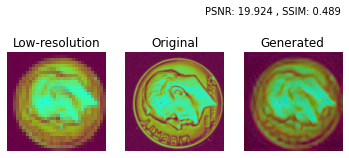

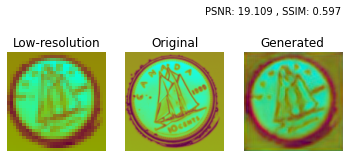

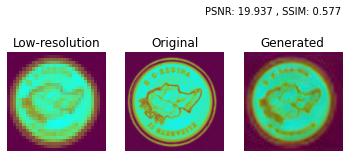

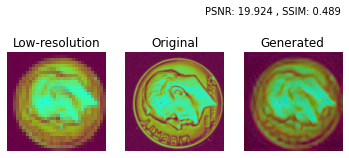

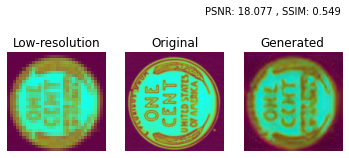

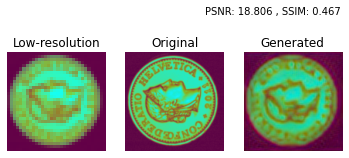

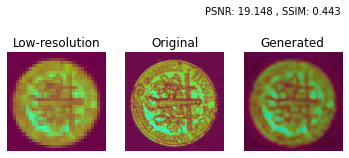

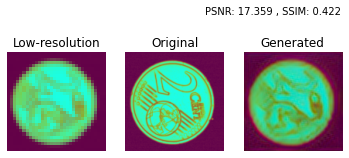

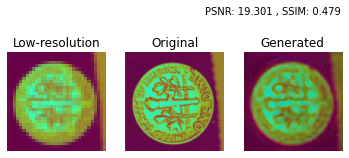

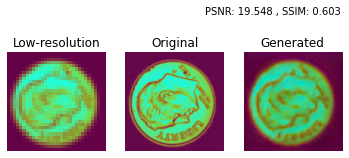

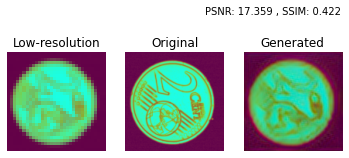

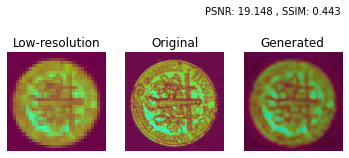

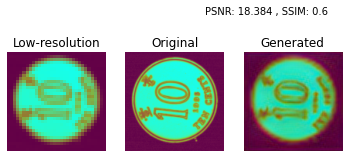

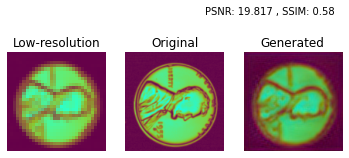

In [ ]:
#predict stuff and visualize results

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0).numpy()


def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0).numpy()

def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    psnr_val = int(PSNR(original_image, generated_image) * 1000)
    ssim_val = int(SSIM(original_image, generated_image) * 1000)
    plt.text(-50, -50, "PSNR: {} , SSIM: {}".format(psnr_val / 1000, ssim_val / 1000))

    plt.savefig(path)

#Normalize Images
for i in range(high_resolution_images.shape[0]):
  img = high_resolution_images[i,:,:]
  maxi = img.max()
  mini = img.min()
  high_resolution_images[i,:,:] = (img-mini)/(maxi-mini)

for i in range(low_resolution_images.shape[0]):
  img = low_resolution_images[i,:,:]
  maxi = img.max()
  mini = img.min()
  low_resolution_images[i,:,:] = (img-mini)/(maxi-mini)
# Generate high-resolution images from low-resolution images
generated_images = generator.predict_on_batch(low_resolution_images)

# Save images
for index, img in enumerate(generated_images):
    save_images(low_resolution_images[index], high_resolution_images[index], img,
                path="./testR/{}".format(index))